# Deep Deterministic Policy Gradient

https://arxiv.org/pdf/1509.02971.pdf

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import numpy as np
import random
import gym
import pdb

from src.utils.OUNoise import OUNoise 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define Networks

In [4]:
class Actor(nn.Module):
    def __init__(self, state_space, action_space):
        super(Actor, self).__init__()
        
        self.noise = OUNoise(action_space)
        
        self.head = nn.Sequential(
            nn.Linear(state_space, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, action_space),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.head(x)
    
    def act(self, state, add_noise=True):
        
        state = torch.from_numpy(state).float().to(device)
        
        action = self.forward(state).cpu().data.numpy()
        if add_noise:
            action += self.noise.noise()

        return np.clip(action, -1, 1)


In [5]:
class Critic(nn.Module):
    def __init__(self, state_space, action_space):
        super(Critic, self).__init__()
        
        self.head = nn.Sequential(
            nn.Linear(state_space, 1024),
            nn.ReLU(),
        )
        
        self.body = nn.Sequential(
            nn.Linear(1024 + action_space, 512),
            nn.ReLU(),
            nn.Linear(512, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )
    
    def forward(self, x, actions):
        x = self.head(x)
        x = self.body(torch.cat((x, actions), dim=1))
        return x

## Create environment with Agents

https://github.com/openai/gym/wiki/Pendulum-v0

In [6]:
import gym

# env_name = "Pendulum-v0"
env_name = "BipedalWalker-v3"
env = gym.make(env_name)

state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]

print("State space: {}".format(state_space))
print("Action space: {}".format(action_space))

State space: 24
Action space: 4


/home/daryl/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
actor = Actor(state_space, action_space).to(device)
critic = Critic(state_space, action_space).to(device)

actor_target = Actor(state_space, action_space).to(device)
critic_target = Critic(state_space, action_space).to(device)

### Replay Buffer

In [8]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=int(buffer_size))
        self.Experience = namedtuple("experience", ["state", "action", "reward", "next_state", "done"])
    
    def push(self, state, action, reward, next_state, done):
        e = self.Experience(state, action, np.array([reward]), next_state ,done)
        self.buffer.append(e)
    
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        
        states = [ exp.state for exp in samples]
        actions = [ exp.action for exp in samples]
        rewards = [ exp.reward for exp in samples]
        next_states = [ exp.next_state for exp in samples]
        dones = [ exp.done for exp in samples]
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.buffer)

## Computing loss and updating Networks

This code has broken up the update for the actor and critic seperately so it's easy to see what's going on.

In [9]:
actor_optimiser = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimiser = optim.Adam(critic.parameters(), lr=1e-3)

In [10]:
def learn():

    state_batch, action_batch, reward_batch, next_state_batch, masks = mem.sample(batch_size)
    
    state_batch = torch.FloatTensor(state_batch).to(device)
    action_batch = torch.FloatTensor(action_batch).to(device)
    reward_batch = torch.FloatTensor(reward_batch).to(device)
    next_state_batch = torch.FloatTensor(next_state_batch).to(device)
    masks = torch.FloatTensor(masks).to(device)

    # Update Critic
    update_critic(
        states=state_batch,
        next_states=next_state_batch,
        actions=action_batch,
        rewards=reward_batch,
        dones=masks
    )
    
    # Update actor
    update_actor(states=state_batch)
    
    # Update target networks
    update_target_networks()

### Actor Update

The **critic** is responsible for calculating the loss from the **actor**. Essentially, we look at the actions that the actor took in the given state, and then work out how good that action was.

<img src="./img/ddpg/actor_update.png" alt="Drawing" style="height: 50px;"/>

This complicated looking formula is basically saying:

> The loss is the average of the estimated Q value from the critic, given the action taken by the actor in a given state.



In [11]:
def update_actor(states):
    actions_pred = actor(states)  
    loss = -critic(states, actions_pred).mean()
    
    actor_optimiser.zero_grad()
    loss.backward()
    actor_optimiser.step()

### Critic Update

The critic update looks very similar to that of a DQN. The loss of the critic is **mean squared error** of the **Q value** which we predicted with our current network, and what the actual reward was + the discounted future reward from our target critic network.

#### Critic Loss:
<img src="./img/ddpg/critic_loss.png" alt="Drawing" style="height: 30px;"/>

#### Critic $y_i$:
<img src="./img/ddpg/critic_yi.png" alt="Drawing" style="height: 35px;"/>

Essentially it is working out:
> How right was I in predicting the current state I am in.

In [12]:
def update_critic(states, next_states, actions, rewards, dones):
    next_actions = actor_target.forward(next_states)
    
    y_i =  rewards + ( gamma * critic_target(next_states, next_actions) * (1-dones ))
    expected_Q = critic(states, actions)

    loss = F.mse_loss(y_i, expected_Q)
    
    critic_optimiser.zero_grad()
    loss.backward()
    critic_optimiser.step()

### Soft Weights Updates

Because the DDPG network is prone to divergance, as with our DQN, we "phase in" the weights from our current network to our target network slowly. This is to give the networks consistant targets during back propogation.

<img src="./img/ddpg/target_update.png" alt="Drawing" style="height:100px;"/>

In [13]:
def update_target_networks():
    for target, local in zip(actor_target.parameters(), actor.parameters()):
        target.data.copy_(tau*local.data + (1.0-tau)*target.data)
        
    for target, local in zip(critic_target.parameters(), critic.parameters()):
        target.data.copy_(tau*local.data + (1.0-tau)*target.data)

## Runner

In [17]:
max_e = 2000
max_t = 700
buffer_size = 100000
batch_size = 32
learn_every = 1

gamma = 0.99
tau = 1e-2

In [18]:
mem = ReplayBuffer(buffer_size)

score_log = []
average_score_log = []
score_window = deque(maxlen=100)

In [19]:
for episode in range(max_e):
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = actor.act(state, add_noise=False)
        next_state, reward, done, _ = env.step(action)
        mem.push(state, action, reward, next_state, done)
        score += reward


        
        if len(mem) > batch_size and t % learn_every == 0:
            learn()

        if done:
            break;
        
        state = next_state
    
    score_log.append(score)
    score_window.append(score)
    average_score_log.append(np.mean(score_window))
    
    print("\rEpsiode: {:.1f}\tWindow Score: {:.4f}\tScore: {:.4f}".format(episode, np.mean(score_window), score), end="")    
    if (episode % 100 == 0):
        print("\rEpsiode: {:.1f}\tWindow Score: {:.4f}\tScore: {:.4f}".format(episode, np.mean(score_window), score))




<ipython-input-12-36e5e9791986>:7: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_i, expected_Q)


Epsiode: 0.0	Window Score: -119.5326	Score: -119.5326
Epsiode: 100.0	Window Score: -108.6696	Score: -103.4488
Epsiode: 200.0	Window Score: -108.9527	Score: -134.9309
Epsiode: 300.0	Window Score: -113.4450	Score: -127.4593
Epsiode: 400.0	Window Score: -114.7104	Score: -102.8233
Epsiode: 500.0	Window Score: -117.8390	Score: -108.5431
Epsiode: 600.0	Window Score: -109.3763	Score: -105.2513
Epsiode: 700.0	Window Score: -106.9208	Score: -78.06558
Epsiode: 800.0	Window Score: -107.3720	Score: -106.2750
Epsiode: 900.0	Window Score: -106.9978	Score: -117.6274
Epsiode: 1000.0	Window Score: -96.8444	Score: -103.0916
Epsiode: 1100.0	Window Score: -108.8564	Score: -109.7025
Epsiode: 1200.0	Window Score: -93.0367	Score: -77.840706
Epsiode: 1300.0	Window Score: -110.3972	Score: -115.3117
Epsiode: 1400.0	Window Score: -116.6776	Score: -113.1296
Epsiode: 1500.0	Window Score: -116.2246	Score: -118.0413
Epsiode: 1600.0	Window Score: -117.7150	Score: -117.8173
Epsiode: 1700.0	Window Score: -118.4970	Scor

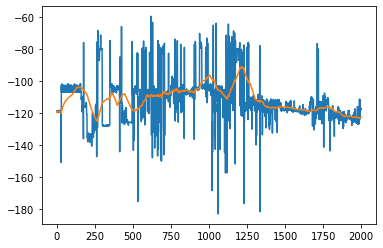

In [20]:
plt.plot(score_log)
plt.plot(average_score_log)

In [20]:
torch.save(actor.state_dict(), "{}_actor_model.pth".format(env_name))
torch.save(critic.state_dict(), "{}_critic_model.pth".format(env_name))

## Watch

In [ ]:
for episode in range(3):
    state = env.reset()
    score = 0
    input()

    for t in range(max_t):
        action = actor.act(state, add_noise=False)
        next_state, reward, done, _ = env.step(action)
        env.render()
        
        score += reward
        
        if done:
            print(score)
            break;

env.close()